# Fine-Tuning BERT on GLUE - QNLI

From [GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding - Wang et al.](https://arxiv.org/pdf/1804.07461):

The Stanford Question Answering Dataset (Rajpurkar et al. 2016) is a question-answering dataset consisting of question-paragraph pairs, where one of the sentences in the paragraph (drawn
from Wikipedia) contains the answer to the corresponding question (written by an annotator). We convert the task into sentence pair classification by forming a pair between each question and each
sentence in the corresponding context, and filtering out pairs with low lexical overlap between the question and the context sentence. The task is to determine whether the context sentence contains
the answer to the question. This modified version of the original task removes the requirement that the model select the exact answer, but also removes the simplifying assumptions that the answer
is always present in the input and that lexical overlap is a reliable cue. This process of recasting existing datasets into NLI is similar to methods introduced in White et al. (2017) and expanded
upon in Demszky et al. (2018). We call the converted dataset QNLI (Question-answering NLI).

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
from pathlib import Path

import numpy as np
from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)
np.random.seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "qnli"

PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA A40

==============NVSMI LOG==============

Timestamp                                 : Sat Jan 18 17:10:44 2025
Driver Version                            : 550.90.07
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:06:00.0
    FB Memory Usage
        Total                             : 46068 MiB
        Reserved                          : 665 MiB
        Used                              : 4 MiB
        Free                              : 45401 MiB
    BAR1 Memory Usage
        Total                             : 65536 MiB
        Used                              : 2 MiB
        Free                              : 65534 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## 1. Dataset

In [5]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [6]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})

In [7]:
pd.DataFrame(dataset["train"]).sample(10)

,question,sentence,label,idx
64724,In what year did Robert Louis Stevenson die?,Mission work in Samoa had begun in late 1830 b...,1,64724
38119,How was the Everton FC's crest redesign receiv...,The redesign was poorly received by supporters...,0,38119
41924,Beyoncé was an honorary chair of the 2013 what?,She was also honorary chair of the 2013 Met Gala.,0,41924
42888,Who was the author of Conversations on the Plu...,Sarah Trimmer wrote a successful natural histo...,1,42888
47148,What is essential for the mating of the elemen...,Antennas are required by any radio receiver or...,0,47148
42142,What are some courses Eton offers in the summe...,These comparatively new developments will run ...,1,42142
19057,"What does ""open mouth operations"" mean?",Fractional deposit lending (changes in the res...,0,19057
69777,Who was the head of state of Swaziland after K...,"Following the elections of 1973, the constitut...",1,69777
32661,Why did Julius Caesar wish to invade Gaul?,When two local tribes began to migrate on a ro...,1,32661
61664,How is the city commonly abbreviated?,This motto was quickly adopted as a city nickn...,1,61664


In [8]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0])
num_labels=2


The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [9]:
pd.DataFrame(dataset["test"]).sample(10)

,question,sentence,label,idx
4443,What does political pressure push to extend to...,This has given the American economy a tendency...,-1,4443
5357,What is the largest general further education ...,Newcastle School for Boys is the only independ...,-1,5357
4686,Pressures greater than what can lead to convul...,Prolonged breathing of an air mixture with an ...,-1,4686
4309,Who did George Westinghouse beat out to light ...,"In 1893, George Westinghouse won the bid to li...",-1,4309
329,What health problem did Tesla have in 1879?,"In December 1878, Tesla left Graz and severed ...",-1,329
2256,How many children did Luther and his wife have?,"Between bearing six children, Hans – June 1526...",-1,2256
756,In what year was the ordination order of trans...,At the 1996 General Conference the ordination ...,-1,756
4418,When did Luther write the Large Catechism?,"In 1529, he wrote the Large Catechism, a manua...",-1,4418
2775,What percentage of American households did ABC...,The network has an estimated national reach of...,-1,2775
2477,What town is surrounded by Jacksonville?,Jacksonville surrounds the town of Baldwin.,-1,2477


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the training dataset to create a custom test dataset for our experiment. We will keep the validation split as it is.

In [10]:
new_train_test_split = dataset['train'].train_test_split(test_size=0.2)
new_train_test_split

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 83794
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 20949
    })
})

In [11]:
dataset['train'] = new_train_test_split['train']
dataset['test'] = new_train_test_split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 83794
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 20949
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [12]:
pd.DataFrame(dataset["test"]).sample(10)

,question,sentence,label,idx
6382,Which individuals usually approved charters fo...,At the time of the emergence of urban town lif...,0,73282
4737,What do conifers use rosin to protect themselv...,"For example, rosin is exuded by conifers as pr...",0,20966
7600,What is the lowest pay grade in the USAF?,Enlisted members of the USAF have pay grades f...,0,51723
16692,Which two former rivers in Palermo are current...,Today both the Papireto river and the Kemonia ...,0,42235
15651,Musical genres that gained popularity in Londo...,"In particular the genres UK garage, drum and b...",0,33468
10765,In what year did the Polish government officia...,Representatives of the Polish government offic...,0,62017
17884,Who must sign these orders for them to be valid?,"All troop deployment and disposition orders, i...",0,72796
7366,What does the of toxin Clostridium tetani rele...,Microorganisms can cause tissue damage by rele...,1,97924
14822,How much did Zocor reduce the chance of dying ...,"After five years, the study concluded the pati...",0,94133
4538,Why has demand for water increased annually on...,The country relies heavily on rain to provide ...,1,59171


## 2. BERT-base

In [13]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [15]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


Max length in split='train': 550
Max length in split='validation': 250
Max length in split='test': 549


The training dataset contains sequences longer than the maximum sequence length for BERT. This will be handled via truncation by our tokenization function:

In [16]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/20949 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [17]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
question,What is the theory about leap year called?
sentence,The Gregorian leap year rule (97 leap years in 400 years) was put forward by Petrus Pitatus of Verona in 1560.
label,0
idx,19748
input_ids,"[101, 2054, 2003, 1996, 3399, 2055, 11679, 2095, 2170, 1029, 102, 1996, 25847, 11679, 2095, 3627, 1006, 5989, 11679, 2086, 1999, 4278, 2086, 1007, 2001, 2404, 2830, 2011, 9004, 7946, 6770, 15590, 1997, 20197, 1999, 29185, 1012, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,101,2054,2003,1996,3399,2055,11679,2095,2170,1029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,2054,2003,15065,1005,1055,28031,1029,102,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101,2040,3373,2008,2895,2734,2000,2022,2579,2000,...,1998.0,2106.0,2025.0,3745.0,1037.0,3522.0,2691.0,11377.0,1012.0,102.0


In [19]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,101,2054,2003,1996,3399,2055,11679,2095,2170,1029,...,0,0,0,0,0,0,0,0,0,0
1,101,2054,2003,15065,1005,1055,28031,1029,102,1000,...,0,0,0,0,0,0,0,0,0,0
2,101,2040,3373,2008,2895,2734,2000,2022,2579,2000,...,1998,2106,2025,3745,1037,3522,2691,11377,1012,102


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [20]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [21]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [22]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task qnli


In [23]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

In [24]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [28]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qnli/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.349200,0.237958,0.904997
2,0.199000,0.254146,0.911221
3,0.115600,0.325217,0.910489
4,0.070700,0.435204,0.911038
5,0.043700,0.463113,0.910489


In [29]:
training_summary_bert_base

TrainOutput(global_step=13095, training_loss=0.155620457553463, metrics={'train_runtime': 1881.021, 'train_samples_per_second': 222.735, 'train_steps_per_second': 6.962, 'total_flos': 2.182991931886056e+16, 'train_loss': 0.155620457553463, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [30]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.25414642691612244,
 'eval_accuracy': 0.9112209408749771,
 'eval_runtime': 7.7203,
 'eval_samples_per_second': 707.618,
 'eval_steps_per_second': 22.149,
 'epoch': 5.0}

In [31]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.3492,11.167923,0.000016,2619,0.237958,0.904997,7.7206,707.586,22.148,NaN,NaN,NaN,NaN,NaN
2,0.1990,18.263336,0.000012,5238,0.254146,0.911221,7.7227,707.393,22.142,NaN,NaN,NaN,NaN,NaN
3,0.1156,0.912033,0.000008,7857,0.325217,0.910489,7.7134,708.252,22.169,NaN,NaN,NaN,NaN,NaN
4,0.0707,33.302151,0.000004,10476,0.435204,0.911038,7.7102,708.539,22.178,NaN,NaN,NaN,NaN,NaN
5,0.0437,7.200752,0.000000,13095,0.463113,0.910489,7.7570,704.265,22.045,1881.021,222.735,6.962,2.182992e+16,0.15562


### Loss and Evaluation Metrics over Training Steps

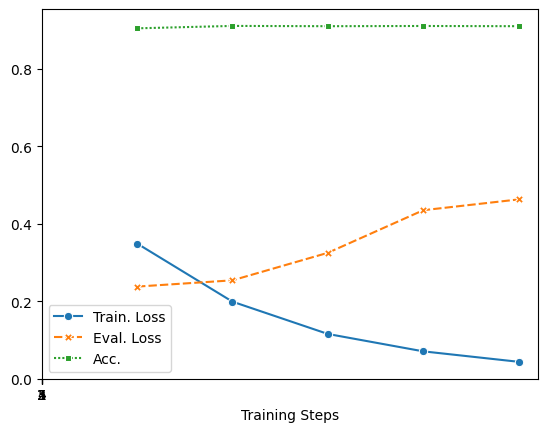

In [32]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_loss", "step", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Acc."]
data = data[:-1]  # drop last row, as this row just contains the values for the best checkpoint again
data = pd.melt(data, ['Training Steps']).dropna()


plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps"))

### 2.4 Evaluation

### Label frequency in test dataset

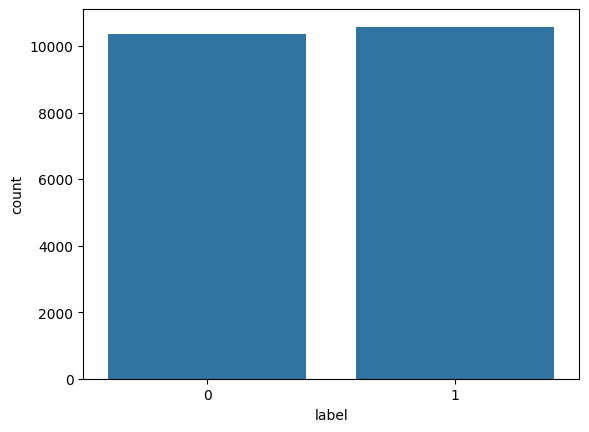

In [33]:
import seaborn as sns

sns.countplot(x='label', data=pd.DataFrame(tokenized_dataset["test"]))

from IPython.display import Markdown, display
display(Markdown("### Label frequency in test dataset"))

The dataset classes seem to be somewhat balanced.

In [34]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-base-uncased)

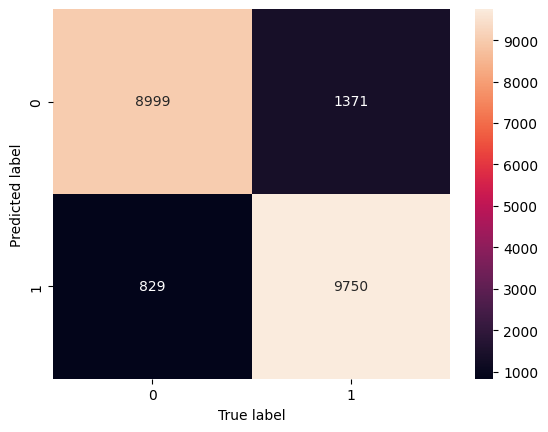

In [35]:
import sklearn.metrics

bert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [36]:
predictions.metrics

{'test_loss': 0.30683404207229614,
 'test_accuracy': 0.8949830540837271,
 'test_runtime': 28.7812,
 'test_samples_per_second': 727.872,
 'test_steps_per_second': 22.758}

In [37]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    [training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [predictions.metrics["test_accuracy"]],
    index=["train_runtime_s"] + list(best_model_evaluation.keys()) + ["test_accuracy"],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-",0.905]
results["original BERT_LARGE"] = ["-", "-","-", 0.927]
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,1881.021000,-,-
eval_loss,0.254146,-,-
eval_accuracy,0.911221,-,-
test_accuracy,0.894983,0.905,0.927


## 3. BERT-Large

In [38]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

In [40]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [41]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task qnli


In [42]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [43]:
BATCH_SIZE = 32  # BERT-large might need a smaller batch size

In [44]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

6755

In [45]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qnli/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.323400,0.206655,0.921838
2,0.162900,0.235416,0.917811
3,0.085600,0.346566,0.915065
4,0.046300,0.434548,0.916712
5,0.024100,0.494360,0.916712


In [47]:
training_summary_bert_large

TrainOutput(global_step=13095, training_loss=0.1284766236167229, metrics={'train_runtime': 5836.8362, 'train_samples_per_second': 71.78, 'train_steps_per_second': 2.244, 'total_flos': 7.732091091471029e+16, 'train_loss': 0.1284766236167229, 'epoch': 5.0})

In [48]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.2066553682088852,
 'eval_accuracy': 0.9218378180486912,
 'eval_runtime': 24.4488,
 'eval_samples_per_second': 223.446,
 'eval_steps_per_second': 6.994,
 'epoch': 5.0}

In [49]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.3234,11.670020,0.000016,2619,0.206655,0.921838,24.4969,223.008,6.980,NaN,NaN,NaN,NaN,NaN
2,0.1629,4.850300,0.000012,5238,0.235416,0.917811,24.4564,223.377,6.992,NaN,NaN,NaN,NaN,NaN
3,0.0856,0.797967,0.000008,7857,0.346566,0.915065,24.4456,223.475,6.995,NaN,NaN,NaN,NaN,NaN
4,0.0463,0.122270,0.000004,10476,0.434548,0.916712,24.4249,223.665,7.001,NaN,NaN,NaN,NaN,NaN
5,0.0241,4.121078,0.000000,13095,0.494360,0.916712,24.4107,223.795,7.005,5836.8362,71.78,2.244,7.732091e+16,0.128477


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-large-uncased)

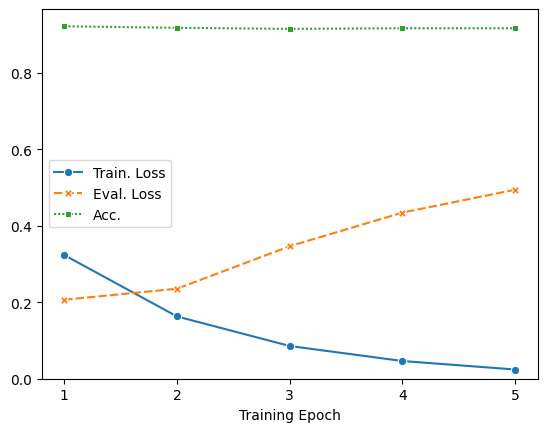

In [50]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [51]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (google-bert/bert-large-uncased)

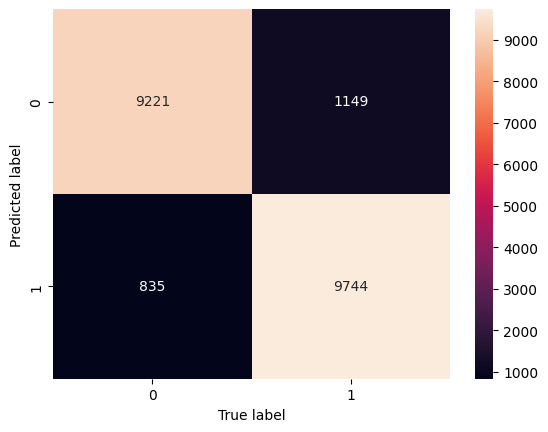

In [52]:
import sklearn.metrics

bert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(bert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [53]:
predictions.metrics

{'test_loss': 0.24505047500133514,
 'test_accuracy': 0.9052938087736885,
 'test_runtime': 90.4929,
 'test_samples_per_second': 231.499,
 'test_steps_per_second': 7.238}

In [54]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,1881.021000,-,5836.836200,-
eval_loss,0.254146,-,0.206655,-
eval_accuracy,0.911221,-,0.921838,-
test_accuracy,0.894983,0.905,0.905294,0.927


## 4. ModernBERT-base

In [55]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [56]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

In [57]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [58]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task qnli


In [59]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [60]:
BATCH_SIZE = 32

In [61]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

9558

In [62]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qnli/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.296100,0.192059,0.929892
2,0.133700,0.237620,0.924950
3,0.052000,0.348336,0.924401
4,0.016700,0.404336,0.928794
5,0.003000,0.615147,0.929709


In [64]:
training_summary_modernbert_base

TrainOutput(global_step=13095, training_loss=0.10029982136787918, metrics={'train_runtime': 1367.5604, 'train_samples_per_second': 306.363, 'train_steps_per_second': 9.575, 'total_flos': 2.9023435904072904e+16, 'train_loss': 0.10029982136787918, 'epoch': 5.0})

In [65]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.1921360343694687,
 'eval_accuracy': 0.9297089511257551,
 'eval_runtime': 4.6626,
 'eval_samples_per_second': 1171.675,
 'eval_steps_per_second': 36.675,
 'epoch': 5.0}

In [66]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.2961,2.199709,0.000064,2619,0.192059,0.929892,4.8569,1124.792,35.208,NaN,NaN,NaN,NaN,NaN
2,0.1337,1.294381,0.000048,5238,0.237620,0.924950,4.8613,1123.785,35.176,NaN,NaN,NaN,NaN,NaN
3,0.0520,0.049314,0.000032,7857,0.348336,0.924401,5.1165,1067.715,33.421,NaN,NaN,NaN,NaN,NaN
4,0.0167,52.961475,0.000016,10476,0.404336,0.928794,4.8924,1116.625,34.952,NaN,NaN,NaN,NaN,NaN
5,0.0030,0.001615,0.000000,13095,0.615147,0.929709,4.8549,1125.251,35.222,1367.5604,306.363,9.575,2.902344e+16,0.1003


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-base)

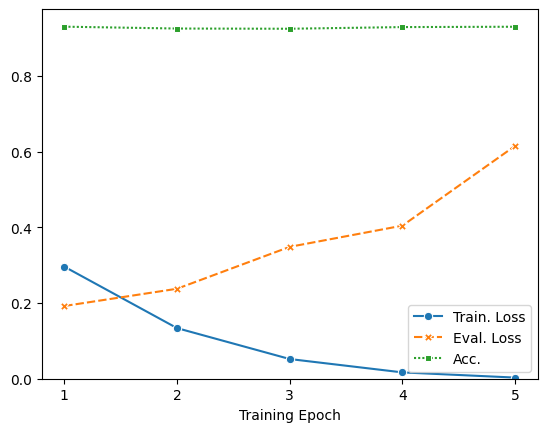

In [67]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [68]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-base)

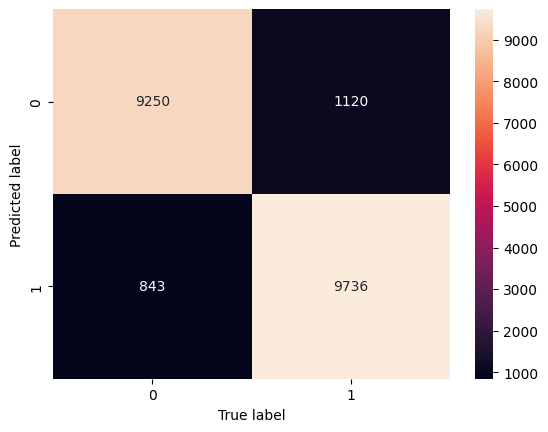

In [69]:
import sklearn.metrics

modernbert_base_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_base_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [70]:
predictions.metrics

{'test_loss': 0.2426108419895172,
 'test_accuracy': 0.9062962432574347,
 'test_runtime': 17.6536,
 'test_samples_per_second': 1186.67,
 'test_steps_per_second': 37.103}

In [71]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,1881.021000,-,1367.560400,5836.836200,-
eval_loss,0.254146,-,0.192136,0.206655,-
eval_accuracy,0.911221,-,0.929709,0.921838,-
test_accuracy,0.894983,0.905,0.906296,0.905294,0.927


## 5. ModernBERT-Large

In [72]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [73]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5463 [00:00<?, ? examples/s]

In [74]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [75]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['accuracy']" as an evaluation metric for the task qnli


In [76]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [77]:
BATCH_SIZE = 32

In [78]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [79]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/e01503441/groups/192.039-2024W/bert/training/glue-qnli/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='accuracy'


Epoch,Training Loss,Validation Loss,Accuracy
1,0.282800,0.193073,0.929892
2,0.132800,0.212759,0.929160
3,0.052500,0.294938,0.926414
4,0.018300,0.367147,0.933004
5,0.003500,0.541119,0.928977


In [81]:
training_summary_modernbert_large

TrainOutput(global_step=13095, training_loss=0.09797907534697985, metrics={'train_runtime': 3018.425, 'train_samples_per_second': 138.804, 'train_steps_per_second': 4.338, 'total_flos': 9.007542881057096e+16, 'train_loss': 0.09797907534697985, 'epoch': 5.0})

In [82]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.3672131896018982,
 'eval_accuracy': 0.9324546952224053,
 'eval_runtime': 9.1683,
 'eval_samples_per_second': 595.857,
 'eval_steps_per_second': 18.651,
 'epoch': 5.0}

In [83]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,
1,0.2828,2.643291,0.000064,2619,0.193073,0.929892,9.8136,556.677,17.425,NaN,NaN,NaN,NaN,NaN
2,0.1328,4.955399,0.000048,5238,0.212759,0.929160,9.8096,556.905,17.432,NaN,NaN,NaN,NaN,NaN
3,0.0525,0.060273,0.000032,7857,0.294938,0.926414,9.8529,554.457,17.355,NaN,NaN,NaN,NaN,NaN
4,0.0183,0.138153,0.000016,10476,0.367147,0.933004,9.8735,553.298,17.319,NaN,NaN,NaN,NaN,NaN
5,0.0035,0.000780,0.000000,13095,0.541119,0.928977,9.8631,553.880,17.337,3018.425,138.804,4.338,9.007543e+16,0.097979


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-large)

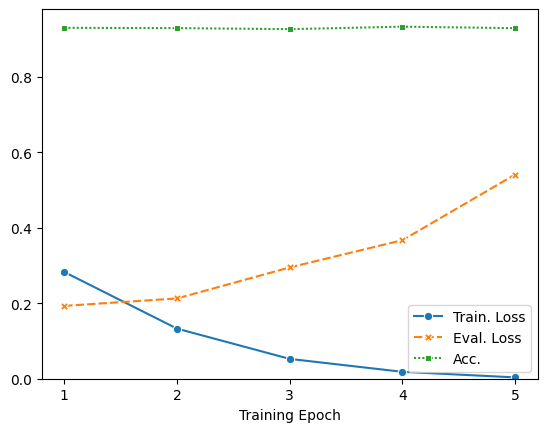

In [84]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [85]:
predictions = trainer.predict(tokenized_dataset["test"])

### Prediction Confusion Matrix (answerdotai/ModernBERT-large)

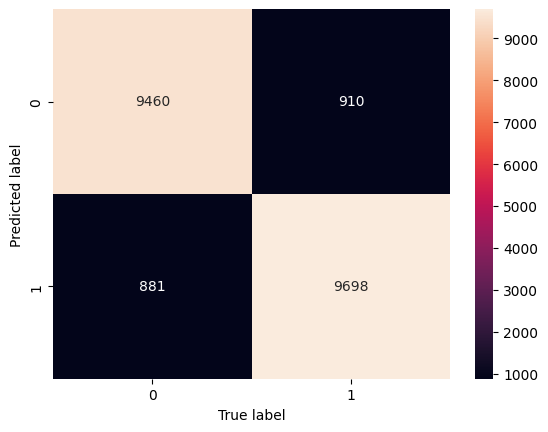

In [86]:
import sklearn.metrics

modernbert_large_cm = sklearn.metrics.confusion_matrix(tokenized_dataset["test"]['label'], predictions.predictions.argmax(-1))
plot = sns.heatmap(modernbert_large_cm, annot=True, fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Predicted label")

from IPython.display import Markdown, display
display(Markdown(f"### Prediction Confusion Matrix ({PRE_TRAINED_CHECKPOINT})"))

In [87]:
predictions.metrics

{'test_loss': 0.48196229338645935,
 'test_accuracy': 0.9145066590290706,
 'test_runtime': 34.6274,
 'test_samples_per_second': 604.983,
 'test_steps_per_second': 18.916}

In [88]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_accuracy"],
    predictions.metrics["test_accuracy"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,1881.021000,-,1367.560400,5836.836200,-,3018.425000
eval_loss,0.254146,-,0.192136,0.206655,-,0.367213
eval_accuracy,0.911221,-,0.929709,0.921838,-,0.932455
test_accuracy,0.894983,0.905,0.906296,0.905294,0.927,0.914507


# Summary

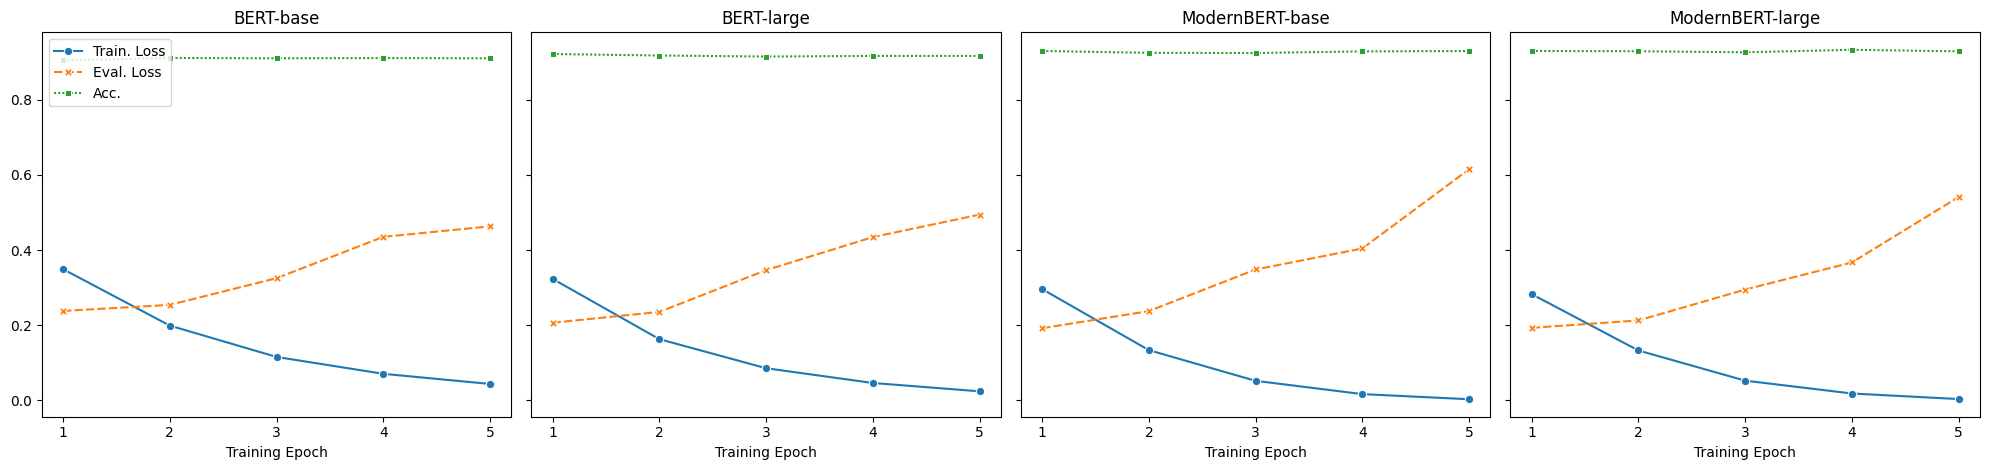

In [89]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(ncols=len(training_histories), sharey=True)

def draw_loss_eval_plot(title, history, ax):
    data = history[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Acc."]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes):
    draw_loss_eval_plot(title, history, ax)

for ax in axes[1:]:
    ax.get_legend().remove()

fig.set_figwidth(20)
fig.tight_layout()

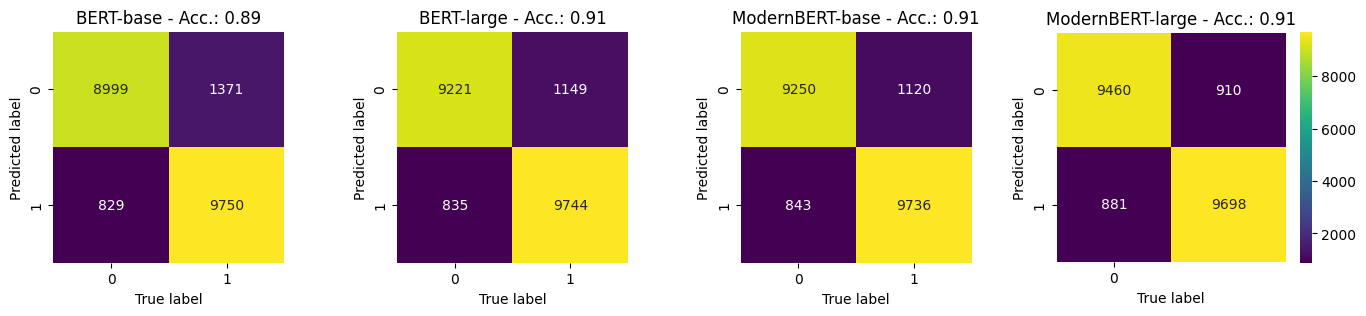

In [90]:
titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
our_results = results.loc["test_accuracy"].drop("original BERT_BASE").drop("original BERT_LARGE")
titles = [title + " - " + f"Acc.: {acc:.2f}" for title, acc in zip(titles, our_results)]
cms = [bert_base_cm, bert_large_cm, modernbert_base_cm, modernbert_large_cm]

fig, axes = plt.subplots(ncols=len(cms),  figsize=(3,3))

def draw_confusion_matrix_plot(title, cm, ax):
    include_cbar = title == titles[-1]
    plot = sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="viridis", cbar=include_cbar, ax=ax)
    plot.set_xlabel("True label")
    plot.set_ylabel("Predicted label")
    plot.set_title(title)

for title, history, ax in zip(titles, cms, axes):
    draw_confusion_matrix_plot(title, history, ax)

fig.set_figwidth(17)

In [91]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,1881.021000,-,1367.560400,5836.836200,-,3018.425000
eval_loss,0.254146,-,0.192136,0.206655,-,0.367213
eval_accuracy,0.911221,-,0.929709,0.921838,-,0.932455
test_accuracy,0.894983,0.905,0.906296,0.905294,0.927,0.914507


In [92]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(1.3754573472586658)

Interestingly all our models perform somewhat similar to the original `BERT-base` model, even our `BERT-large` model can not achieve the performance of the original `BERT-large` model. Only our `ModernBERT-large` model comes close to the accuracy score of the original `BERT-large` model. On the other hand we see a major speedup of `ModernBERT-base` compared to `BERT-base` of 1.38